# **scNET: Learning Context-Specific Gene and Cell Embeddings by Integrating Single-Cell Gene Expression Data with Protein-Protein Interaction Information**

## **Creating the workspace**

**Mount your drive**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

PATH = "/content/gdrive/MyDrive"
%cd $PATH

Mounted at /content/gdrive
/content/gdrive/MyDrive


**Clone GitHub repository - First time Only**


In [ ]:
!git clone https://github.com/madilabcode/scNET

In [2]:
%cd "./scNET"

/content/gdrive/MyDrive/scNET


**Download example data - as an h5ad object**

In [ ]:
import gdown
download_url = f'https://drive.google.com/uc?id=1CQu1aZDVfLSu4Tfuj5Qv3HGw-RnHAWIL'
output_path = './Data/example.h5ad'
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1CQu1aZDVfLSu4Tfuj5Qv3HGw-RnHAWIL
From (redirected): https://drive.google.com/uc?id=1CQu1aZDVfLSu4Tfuj5Qv3HGw-RnHAWIL&confirm=t&uuid=7eaaa80d-17d9-458d-877f-b1f75dfdf6e5
To: /content/gdrive/MyDrive/scNET/Data/example.h5ad
100%|██████████| 1.38G/1.38G [00:07<00:00, 192MB/s]


'./Data/example.h5ad'

**Downlaod Packages**

In [ ]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

#!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install scanpy
!pip install mygene
!pip install gseapy
!pip install matplotlib datashader bokeh holoviews scikit-image colorcet igraph leidenalg

**Imports**

In [ ]:
import os
import torch
from main import main
import warnings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

## Train the model
### Here we trained the model for  250 epochs to demonstrate the usage of the framework, 250 epochs should take around 1 hour of run time on a GPU.

In [ ]:
main(path = r"./Data/example.h5ad", pre_processing_flag=False, human_flag=False, number_of_batches=10, split_cells= True, max_epoch=250, model_name = "_GBM")

N genes: (11049, 9172)
None
3
row loss:12.877086639404297, col loss:19.963428497314453
Epoch: 000, AUC: 0.8615, AP: 0.8759
row loss:12.107040405273438, col loss:16.656951904296875
Epoch: 010, AUC: 0.8340, AP: 0.8607
row loss:10.782108306884766, col loss:13.524980545043945
Epoch: 020, AUC: 0.8405, AP: 0.8737
row loss:10.507050514221191, col loss:12.765357971191406
Epoch: 030, AUC: 0.8457, AP: 0.8782
row loss:10.36837100982666, col loss:12.116954803466797
Epoch: 040, AUC: 0.8522, AP: 0.8833
row loss:10.191774368286133, col loss:11.522177696228027
Epoch: 050, AUC: 0.8705, AP: 0.8964
row loss:9.985088348388672, col loss:11.074166297912598
Epoch: 060, AUC: 0.8766, AP: 0.9023
row loss:9.835799217224121, col loss:10.704724311828613
Epoch: 070, AUC: 0.8737, AP: 0.9006
row loss:9.779376983642578, col loss:10.505216598510742
Epoch: 080, AUC: 0.8764, AP: 0.9025
row loss:9.905036926269531, col loss:10.301002502441406
Epoch: 090, AUC: 0.8677, AP: 0.8945
row loss:9.801613807678223, col loss:10.19236


### **The following parameters need to be provided to the main function in order to start training the model:**

**path:** The directory for the h5ad object.

**human_flag:** Is the data from human (True) or mouse (False)?

**pre_processing_flag:** Should a basic pre-processing pipeline be applied to the object?

**number_of_batches:** The number of batches for the training.

**split_cells:** If the number of cells is too large, we should split the cells into subsets to reduce GPU memory consumption. If true, the cells will be split.

**model_name:** A unique name for the project, which will be used in the outputs of the model.

### **The function will save the following:**

**cell_embedding:** A new dense representation of the cells under the Embedding folder.

**gene_embedding:** A new dense representation of the genes under the Embedding folder.

**out_features:** The reconstructed gene expression profiles.

**trained_model:** The complete trained model under the Models folder.

**new_knn:** The new and pruned KNN network, but only if the split_cells flag is set to False.


## Using the model's outputs

**Load the orignal object**

In [5]:
import scanpy as sc
import pandas as pd
from Utils import load_obj
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
obj = sc.read(r"./Data/example.h5ad")
cell_types = {"0":"Macrophages","1":"Macrophages","2":"CD8 Tcells","3":"Microglia","4":"Cancer","5":"CD4 Tcells","6":"B Cells","10":"Prolifrating Tcells","8":"Cancer","11":"NK"}
obj.obs["Cell Type"] = obj.obs.seurat_clusters.map(cell_types)
sc.tl.umap(obj)

**Load all the relevant embeddings**


In [6]:
import coEmbeddedNetwork as cen
import imp
gene_embedding, cell_embedding, node_features, out_features = cen.load_embeddings("_GBM")


**Create Scanpy object based on the reconstructed gene expression**


In [7]:
adata = cen.create_reconstructed_obj(node_features, out_features, obj)

/content/gdrive/MyDrive/scNET/coEmbeddedNetwork.py:77: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,resolution=0.6)
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_leiden.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[key_added] = pd.Categorical(


**Plot marker genes**

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


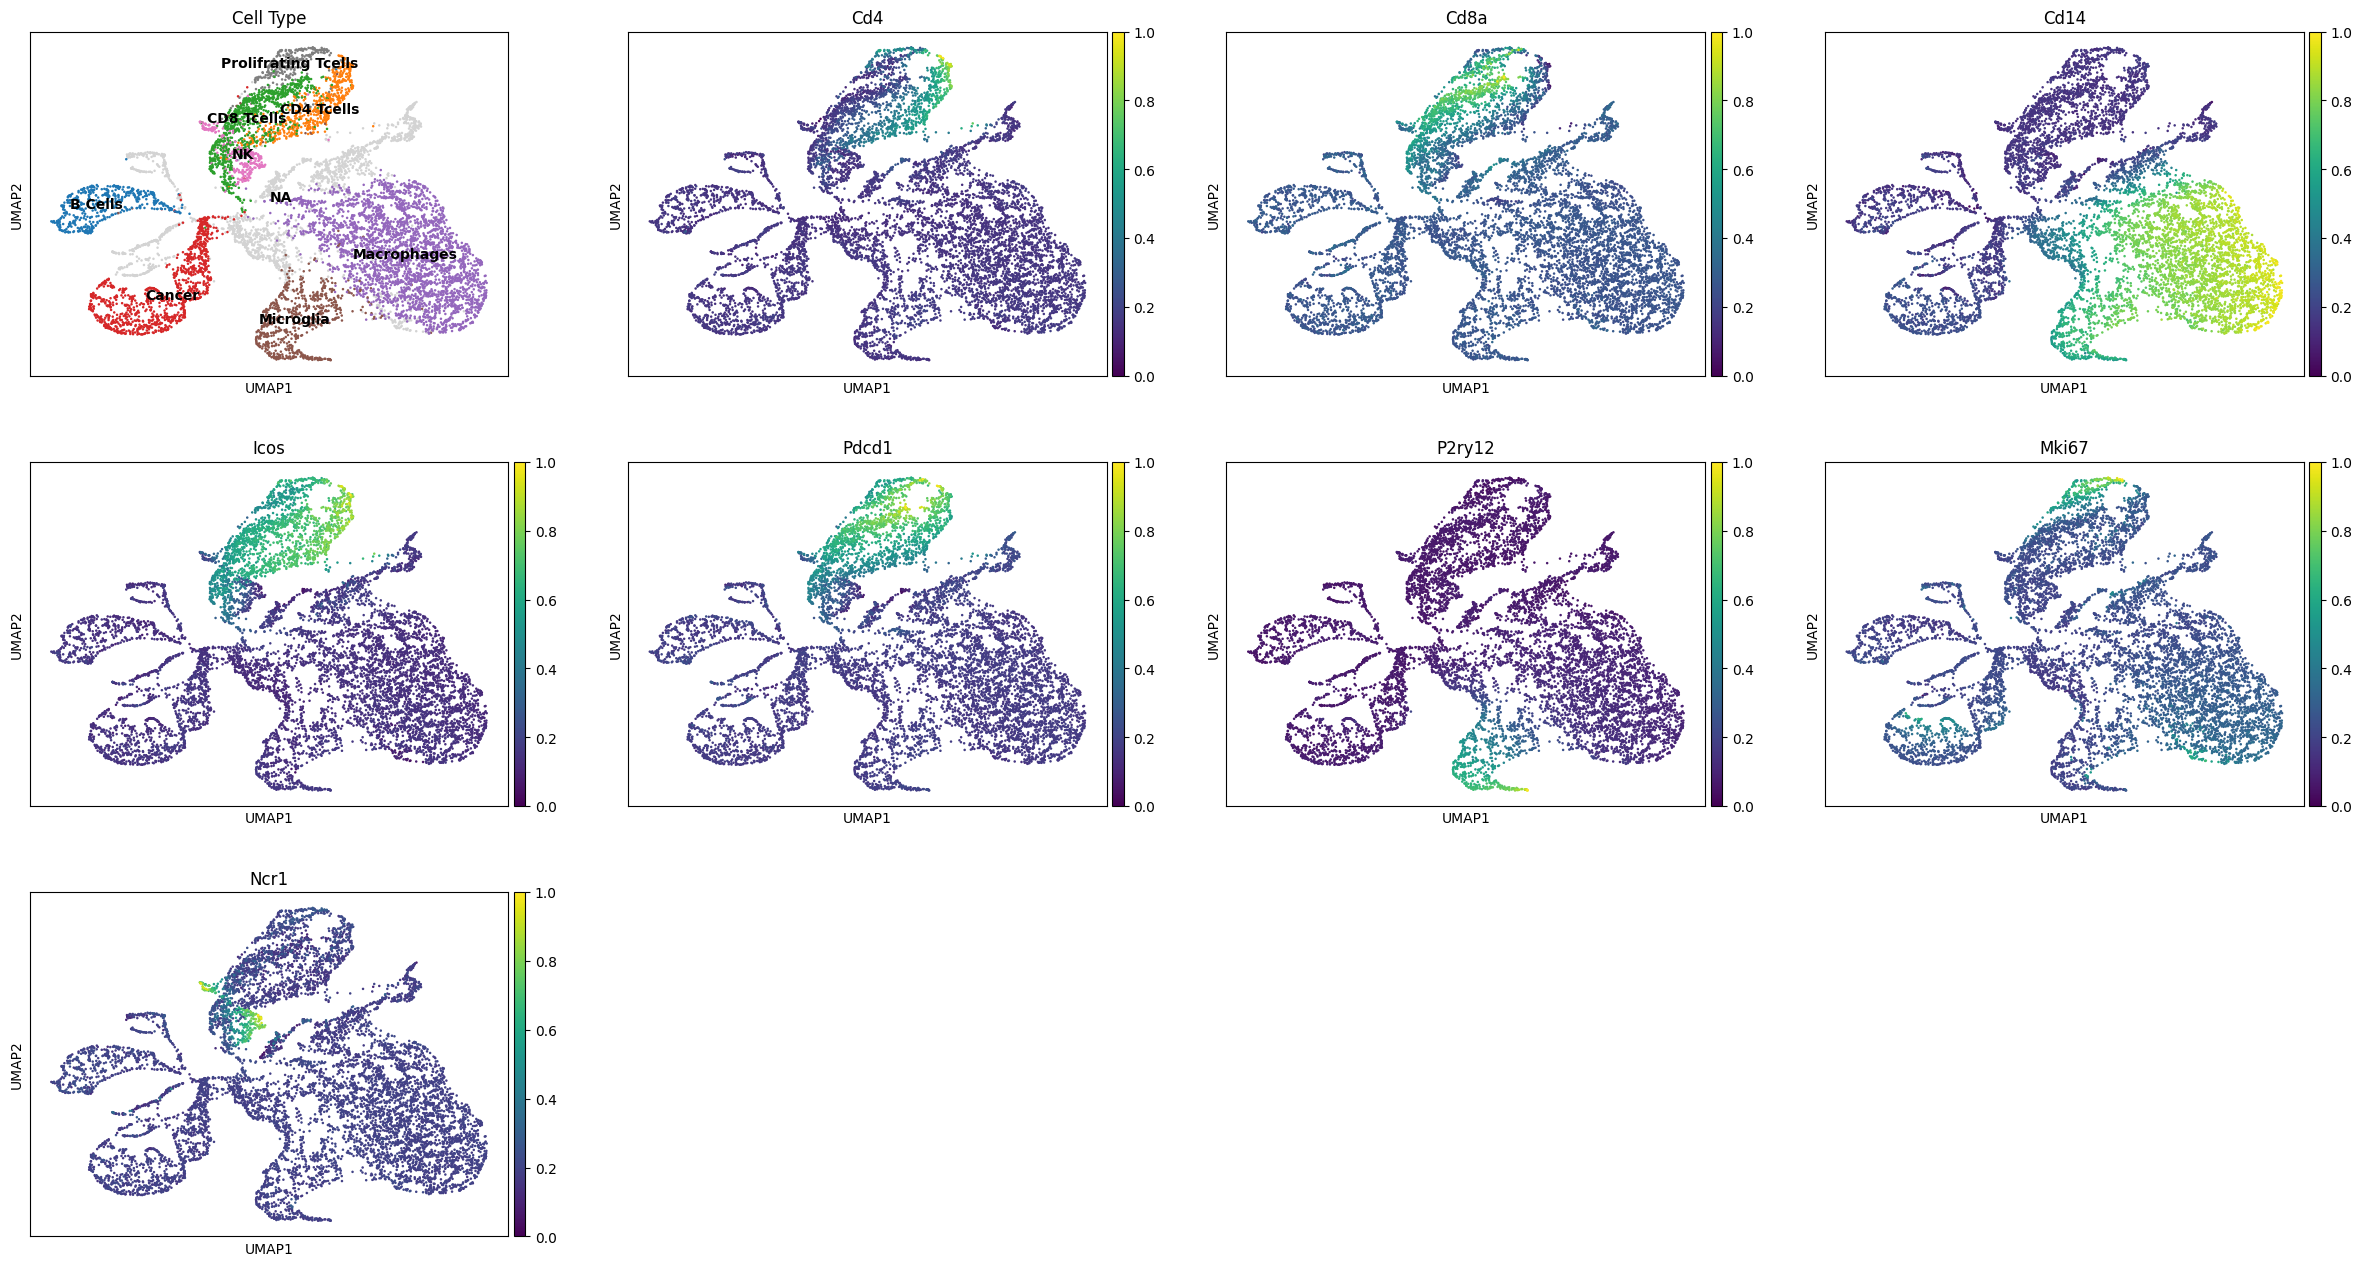

In [8]:
sc.pl.umap(adata, color=["Cell Type","Cd4","Cd8a","Cd14","Icos","Pdcd1","P2ry12","Mki67","Ncr1"], show=True, legend_loc='on data')


**AUPR of marker gene expression for identifying different cell types (scNET)**



In [9]:
cen.cal_marker_gene_aupr(adata)

AUPR for Cd4 in identifying CD4 Tcells: 0.8587
AUPR for Cd8a in identifying CD8 Tcells: 0.6796
AUPR for Cd14 in identifying Macrophages: 0.9616
AUPR for P2ry12 in identifying Microglia: 0.9577
AUPR for Ncr1 in identifying NK: 0.9352


**AUPR of marker gene expression for identifying different cell types (counts)**


In [10]:
cen.cal_marker_gene_aupr(obj)

AUPR for Cd4 in identifying CD4 Tcells: 0.6328
AUPR for Cd8a in identifying CD8 Tcells: 0.5068
AUPR for Cd14 in identifying Macrophages: 0.7964
AUPR for P2ry12 in identifying Microglia: 0.6870
AUPR for Ncr1 in identifying NK: 0.4007


**Finding top 20 enriched pathways for different cell types after DE
analysis for scNET and the orignal gene expressio**


<Figure size 1000x3000 with 0 Axes>

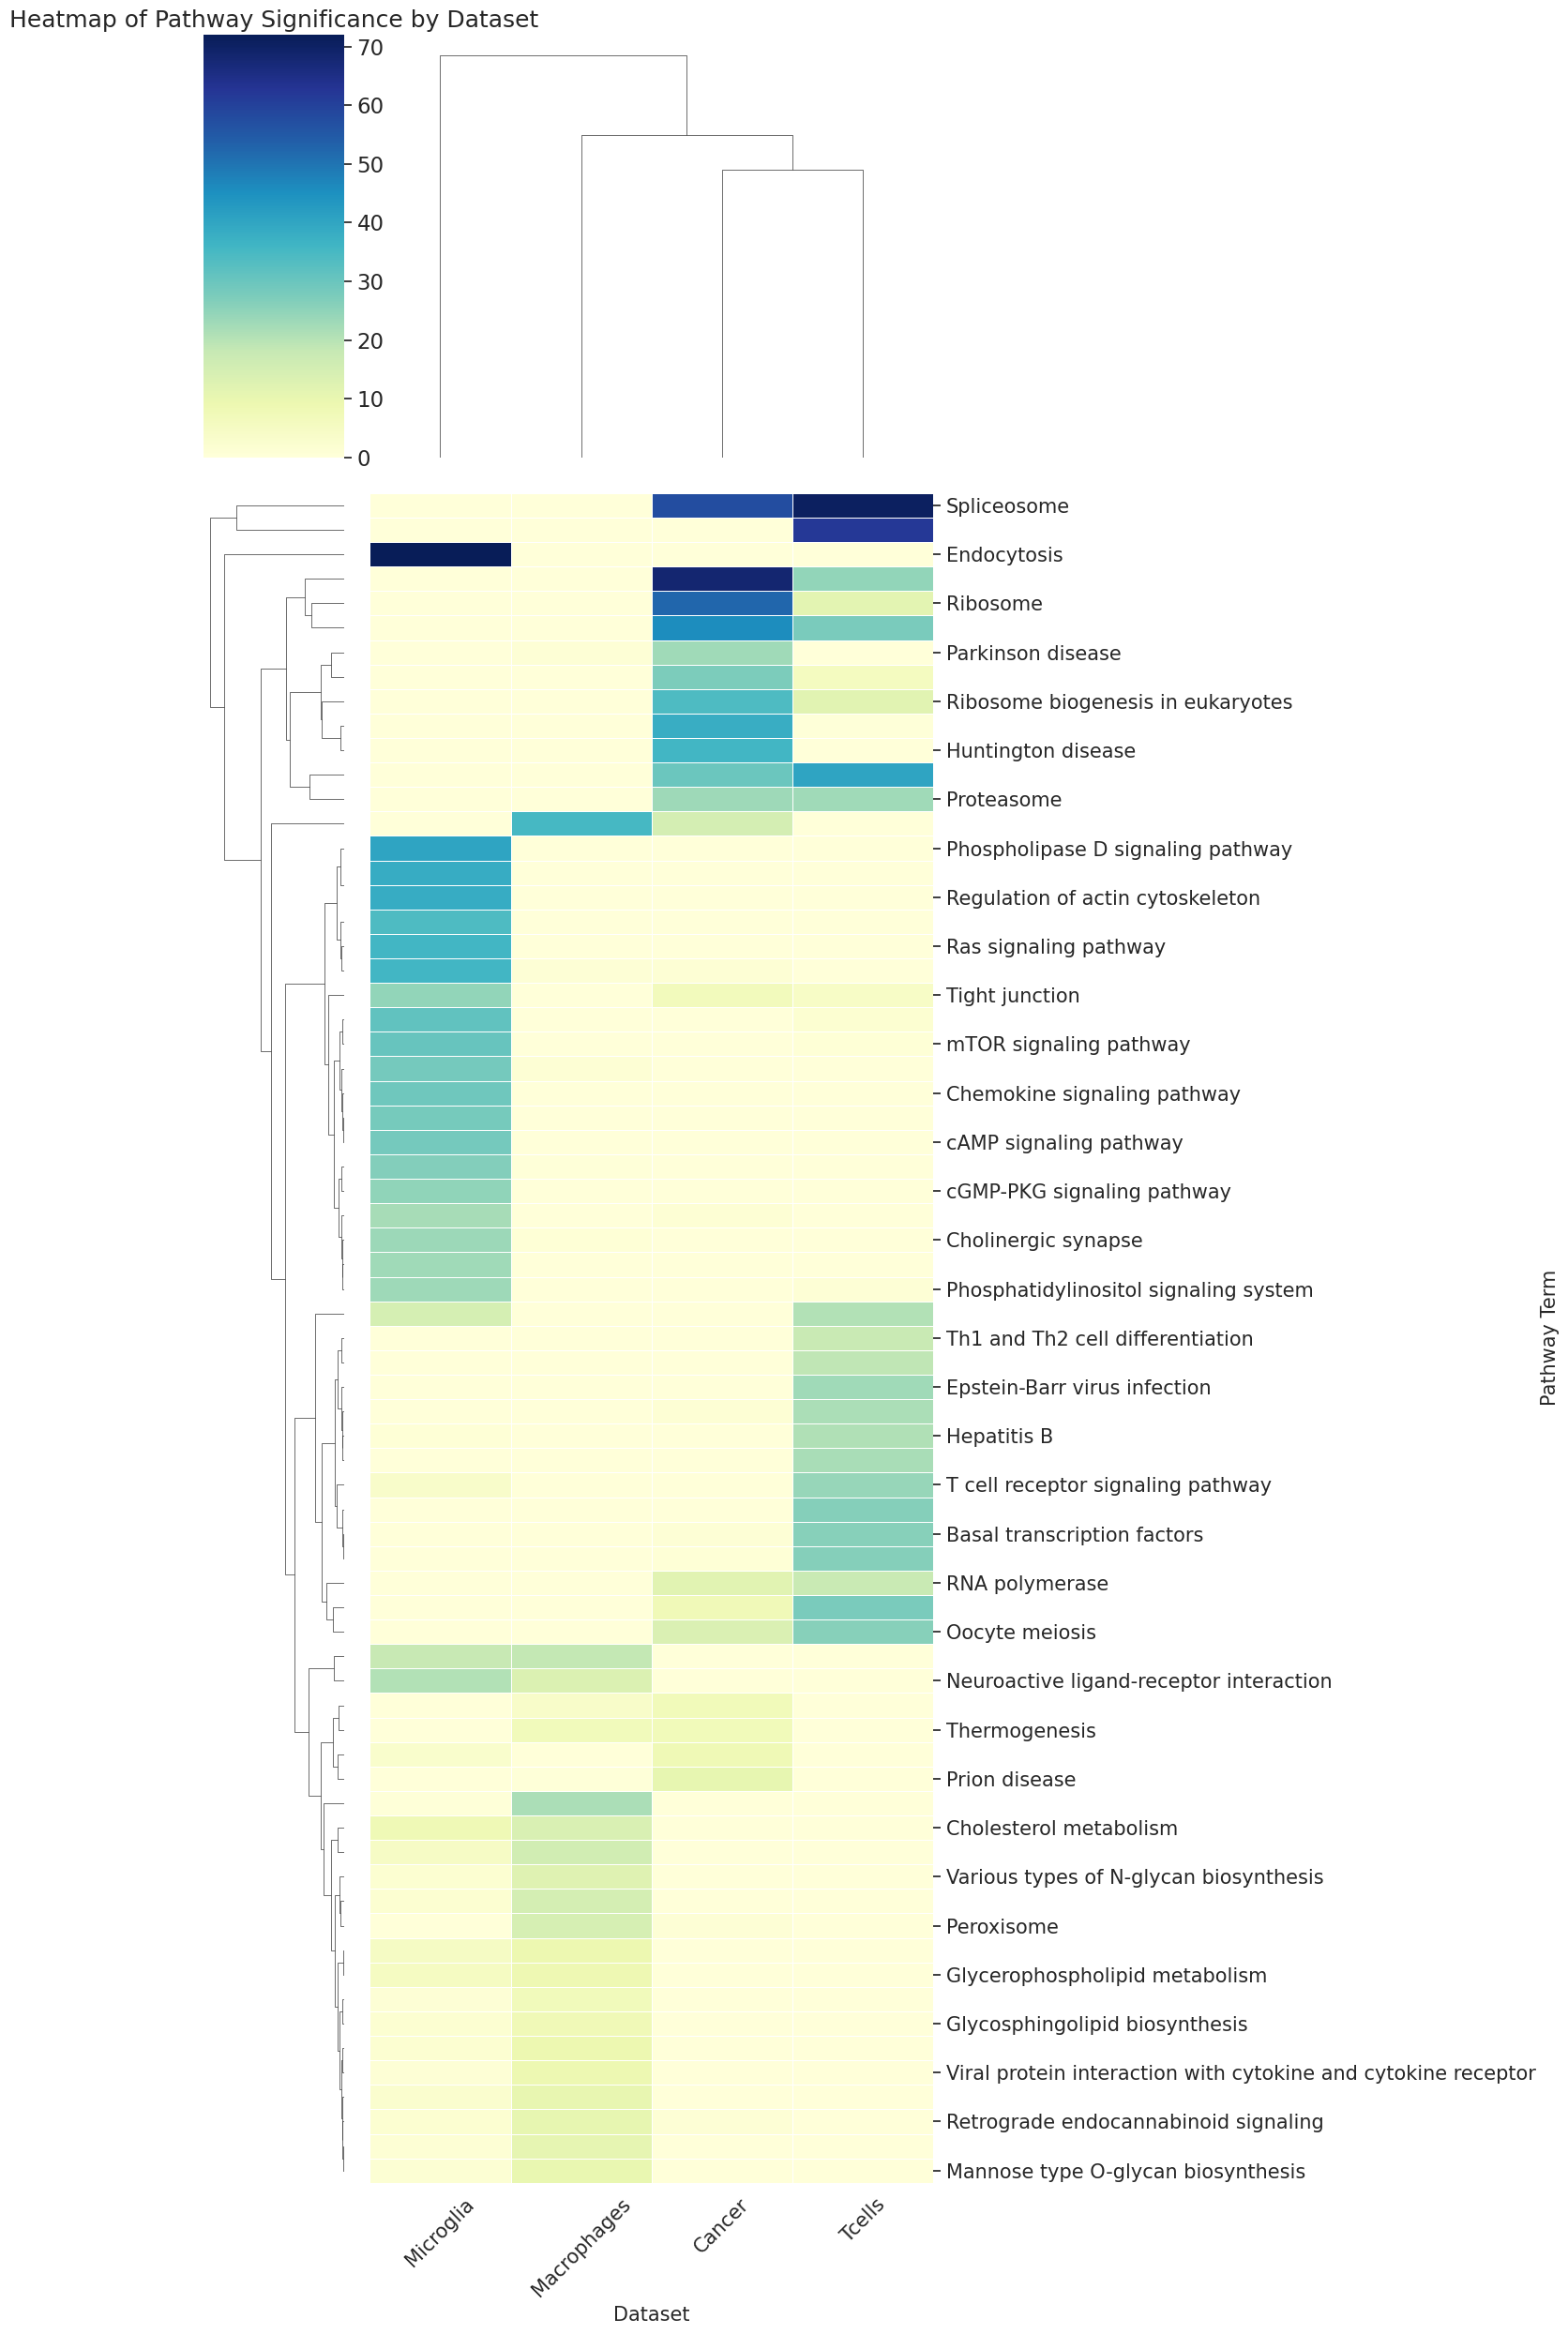

<Figure size 1000x3000 with 0 Axes>

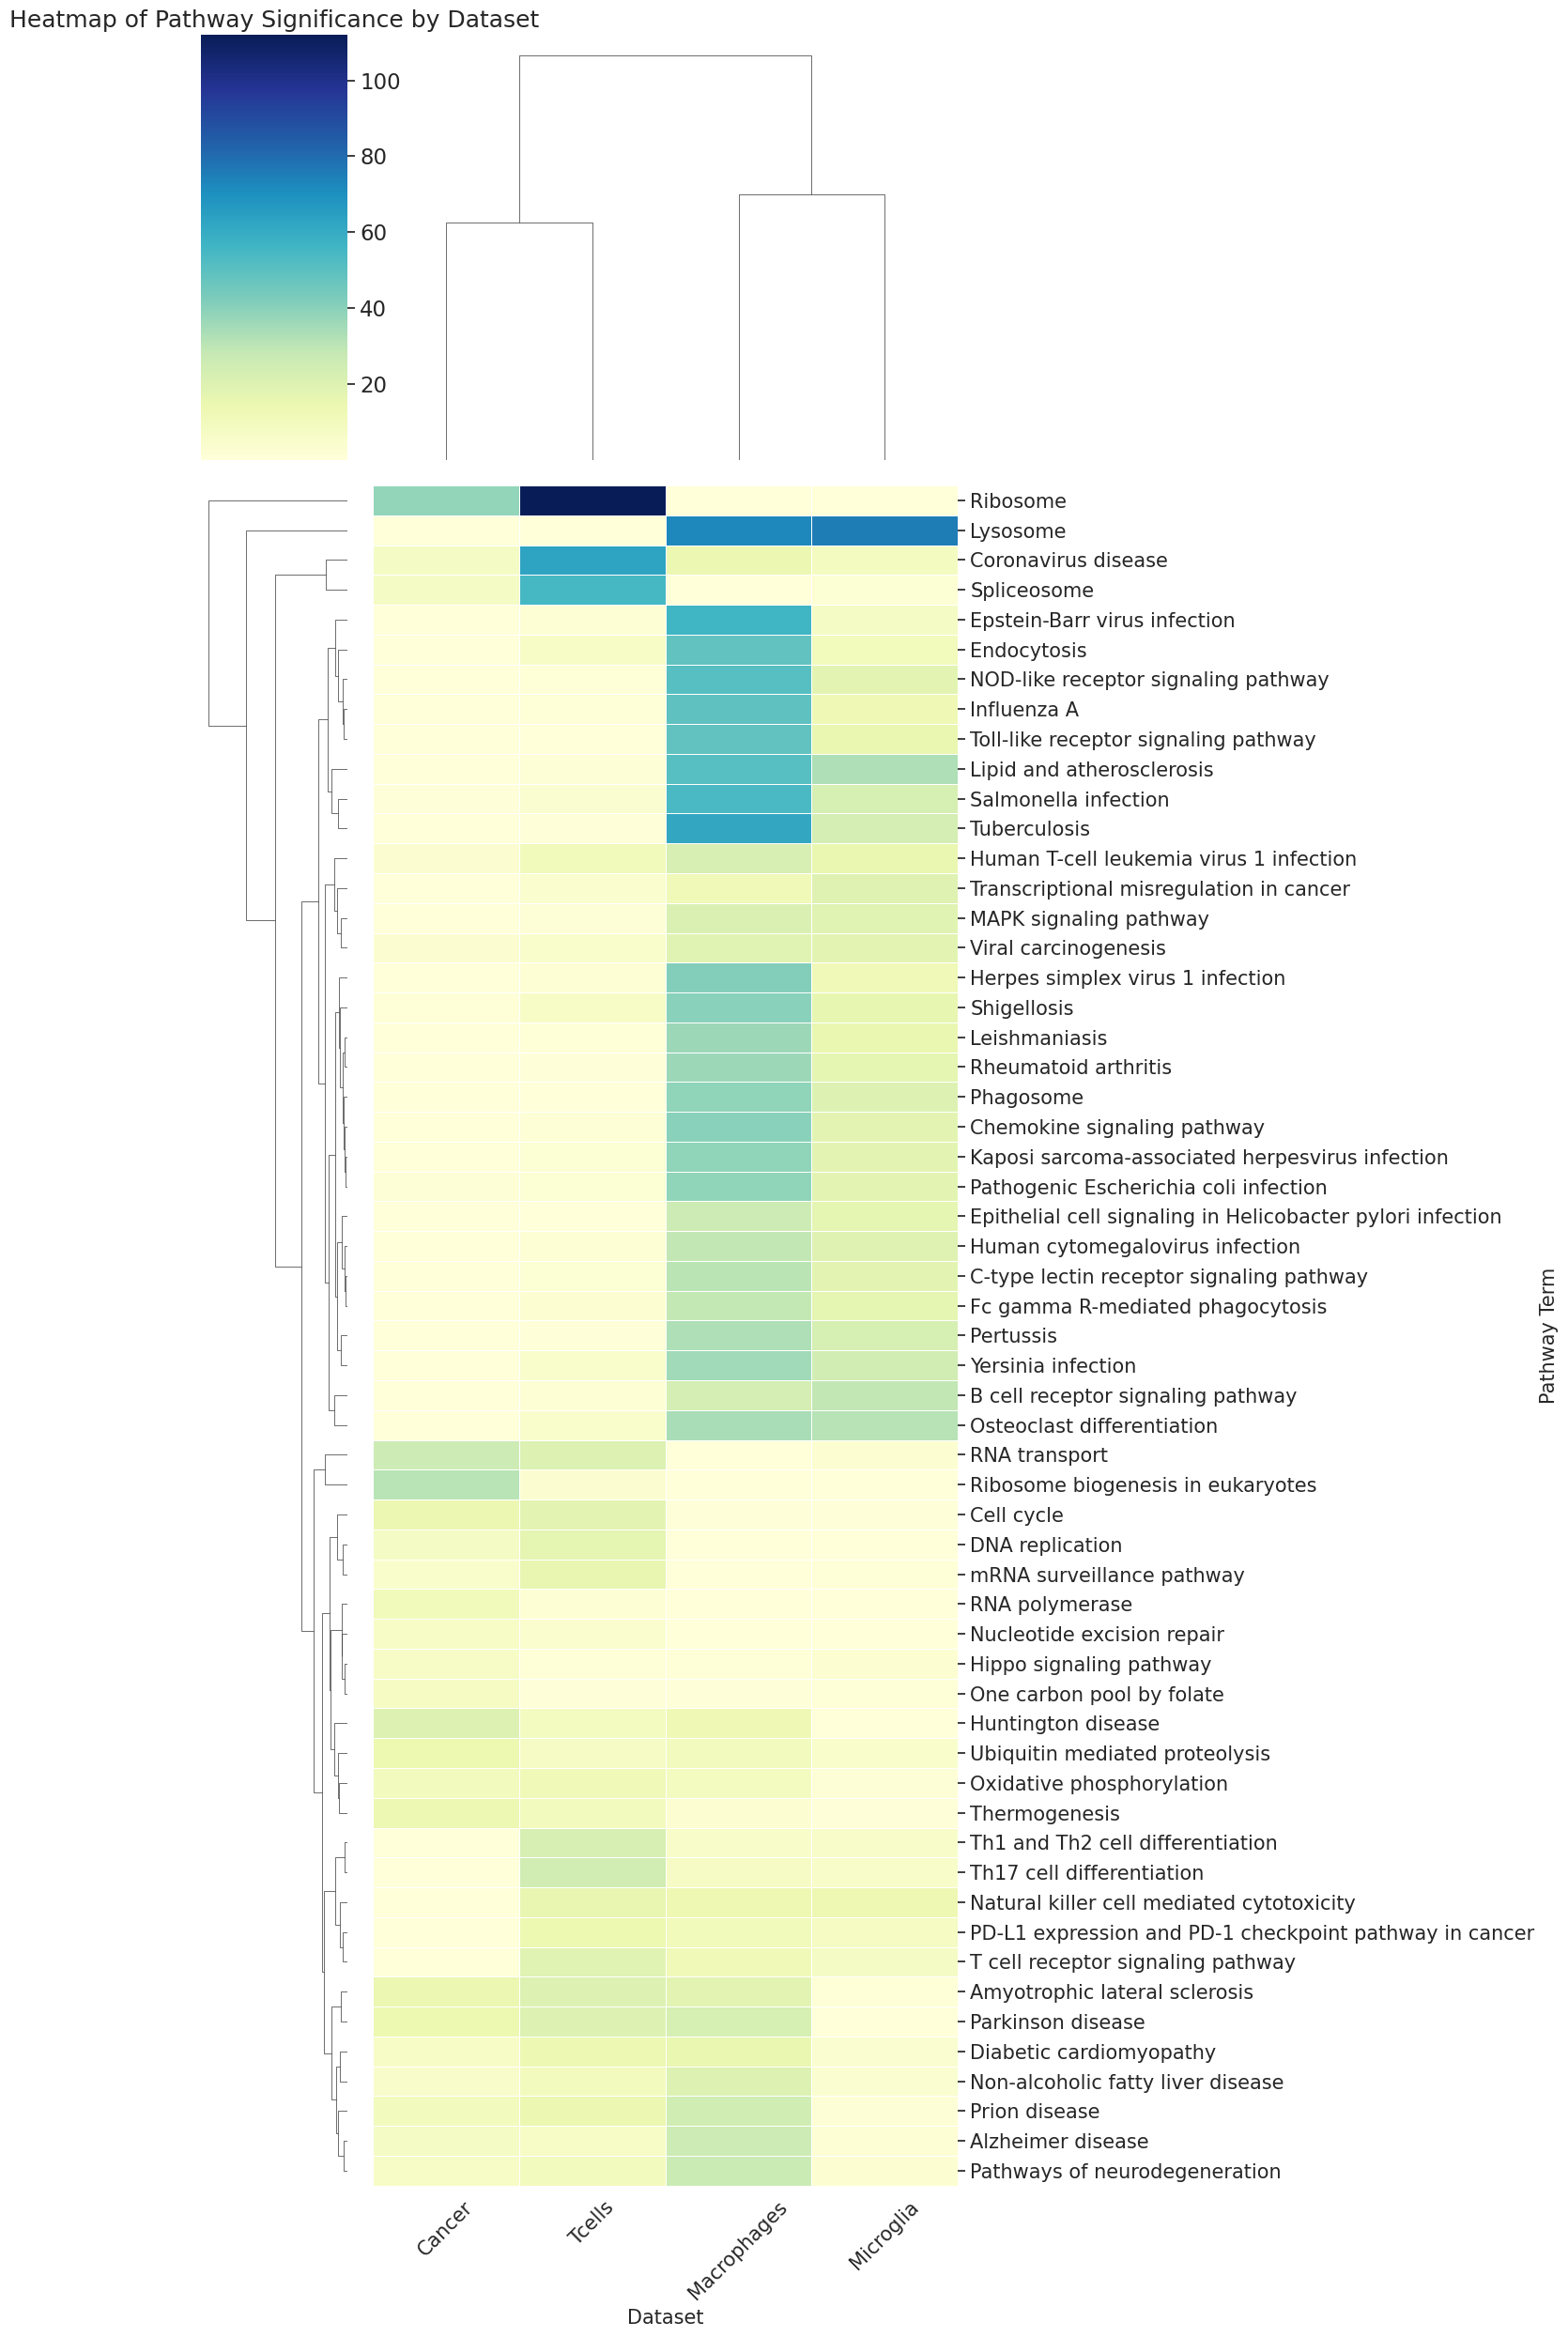

In [39]:
imp.reload(cen)
adata.obs["Cell Type"] = adata.obs["Cell Type"].apply(lambda x: "Tcells" if not x is None and str(x).find("Tcell") >=0 else x )
obj.obs["Cell Type"] = obj.obs["Cell Type"].apply(lambda x: "Tcells" if not x is None and str(x).find("Tcell") >=0 else x )

de_genes_per_group, significant_pathways, filtered_kegg, enrichment_results= cen.pathway_enricment(adata.copy()[adata.obs["Cell Type"].isin(["Macrophages","Tcells","Cancer","Microglia"])],groupby="Cell Type")
cen.plot_de_pathways(significant_pathways,enrichment_results)
de_genes_per_group, significant_pathways, filtered_kegg, enrichment_results= cen.pathway_enricment(obj.copy()[obj.obs["Cell Type"].isin(["Macrophages","Tcells","Cancer","Microglia"])],groupby="Cell Type")
cen.plot_de_pathways(significant_pathways,enrichment_results)

**Creating the co-embedded network, is it modular?**

In [29]:
graph, mod = cen.build_co_embeded_network(gene_embedding, node_features)
mod

0.7790499315694057

**Now we can use the network to predict KEGG pathway membership in a cross-validation**

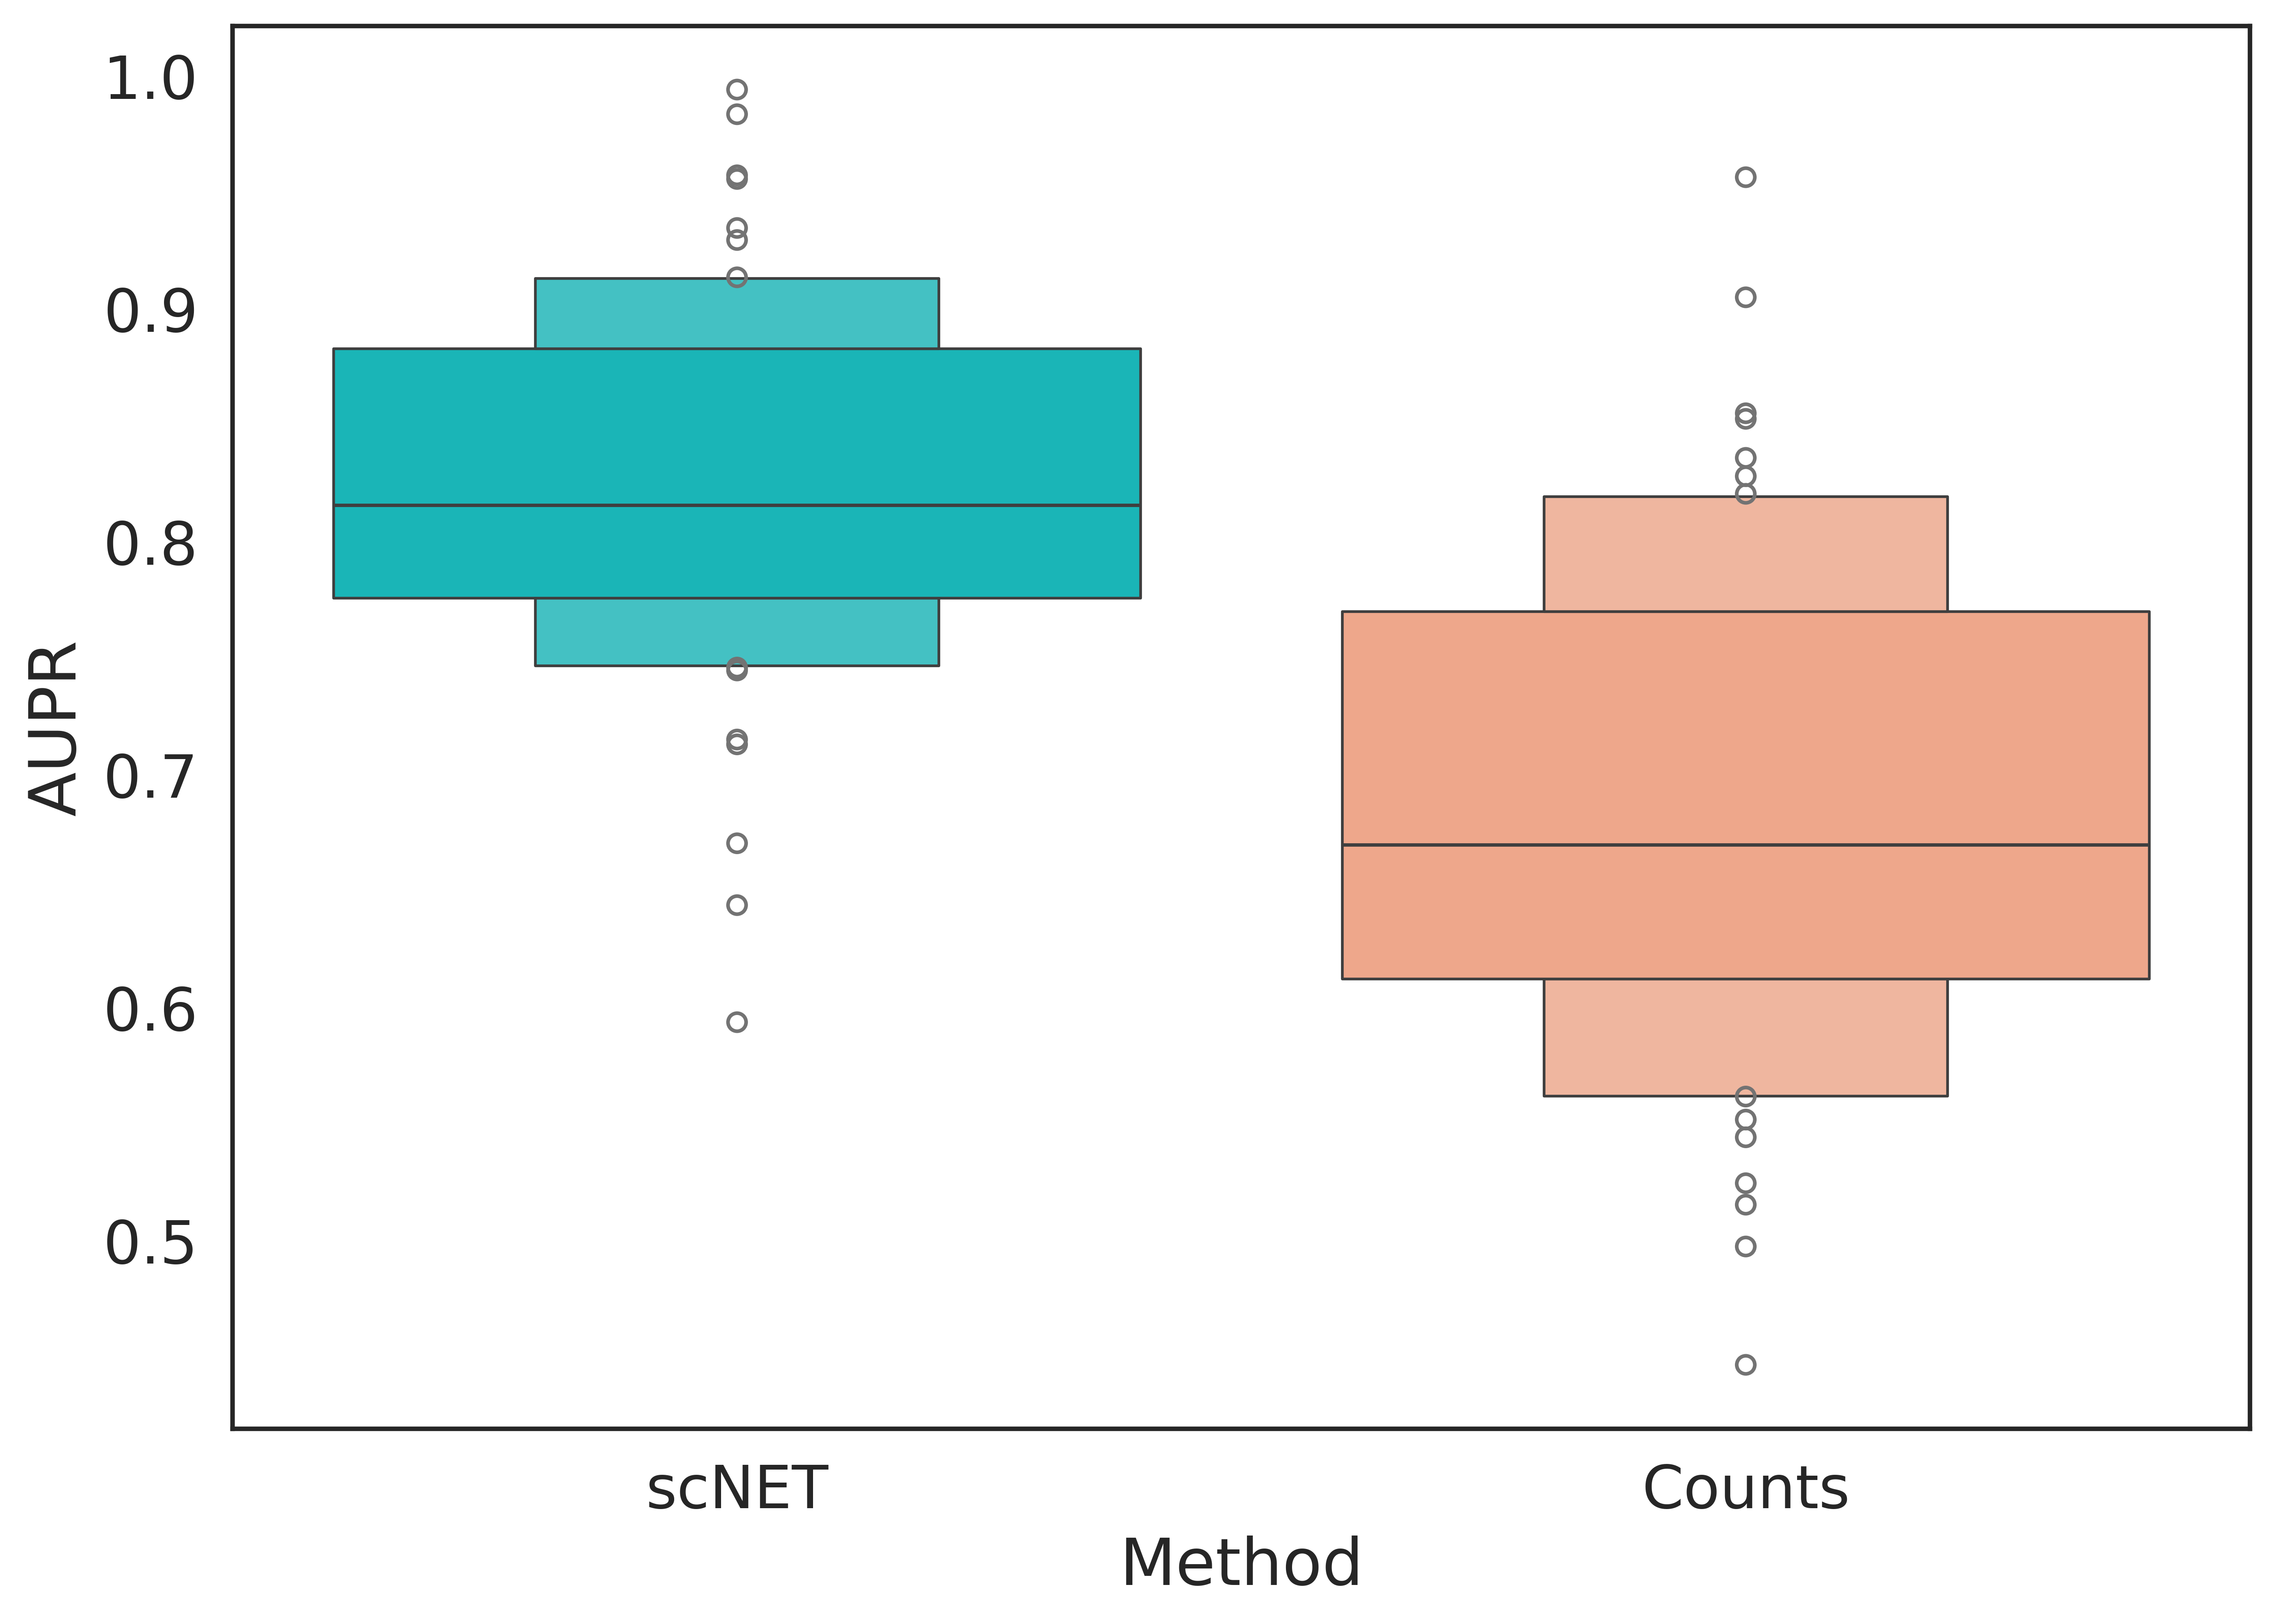

,AUPR,Method
0,0.822945,scNET
1,0.644047,scNET
2,0.789564,scNET
3,0.803965,scNET
4,0.913557,scNET
...,...,...
95,0.773224,Counts
96,0.630073,Counts
97,0.665331,Counts
98,0.620139,Counts


In [37]:
import imp
imp.reload(cen)
cen.predict_kegg(gene_embedding,node_features)

In [ ]:
results_embedd, results_counts = cen.run_p_enr_on_range_clusterts(gene_embedding,[node_features],node_features.index)